# 2 Network Analysis

The Network Analysis of Grey's Anatomy focuses on the three main parts 
1. Setting up the Network
2. Basic analysis of the network statistics
3. Degree analyses of the netwokr

In [8]:
!pip install networkx
import pandas as pd
import networkx as nx
import random
import json
import numpy as np
import re
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
%matplotlib inline

You should consider upgrading via the '/root/venv/bin/python -m pip install --upgrade pip' command.


## 2.1 Network setup

The Grey's Anatomy network will be set up by using the cleaned characters dataframe from the Data Collection. 

The network will be setup by creating a node for each character in the characters dataframe and adding links between the character nodes if another character is mentioned on a characters wikipage. Also, a node attribute containing the main universe of the character, Grey's Aanatomy, Private Practice or Station 19, will be added.

In [9]:
# loading the characters dataframe 
df = pd.read_csv("data/characters.csv")

In [10]:
# getting the links of each character to other characters
df['outlinks_clean'] = ""
df['outlinks_clean'] = df['outlinks_clean'].astype('object')
df['character_links'] = ""
df['character_links']  = df['character_links'] .astype('object')

for index, row in df.iterrows():
    title = row['file']
    pageid = str(row['pageid'])
    
    f = open("data/character wikipages/" + title + ".json")
    data = json.load(f)
    text = json.dumps(data)
    
    
    res = re.findall(r"\[\[.*?\]\]", text)
    res_clean = []
    for element in res:
        element = element.strip("[[").strip("]]")
        res_clean.append(element)
    
    df.at[index, 'outlinks_clean'] = res_clean
        
    links_clean = []
    for element in res_clean:
        element = element.split("|")[0]
        if element in df.title.tolist():
            links_clean.append(element)
    
    single_links = list(set(links_clean))
        
    df.at[index, 'character_links'] = single_links

In [11]:
# function for setting up the network with the character nodes
def set_up_network(net, character, universe_c, universe_encoded):
    # add nodes for the character with the attribute which universe 
    net.add_node(character, universe=universe_c, universe_enc = universe_encoded)

# function for creating the links between the characters based on the links
def add_links_to_network(net, character, links_clean):
    for link in links_clean:
        net.add_edge(character, link)

In [12]:
# creating the network with the setup and link adding functons
ga_net = nx.DiGraph()
for index, row in df.iterrows():
    name = row['title']
    links_clean = row['character_links']
    universe_c = row['main_universe']
    universe_enc = row['universe_encoded']
    
    set_up_network(ga_net, name, universe_c, universe_enc)
    add_links_to_network(ga_net, name, links_clean)

## 2.2 Basic network analysis

The first step of the network analysis is getting the basic statistics such as number of nodes, edges and isolates. Second, the isolates are inspected and as they are, in fact, minor characters of the show, they are being removed from the network for further analysis. Thirdly, a visualization of the network with the characters colored based on the main show of the character is created to get an overview of the network.

In [13]:
# print the main informaion of the network 
num_nodes = ga_net.number_of_nodes()
num_edges = ga_net.number_of_edges()
num_isolates = len(list(nx.isolates(ga_net)))
print("The number of nodes of the Grey's Anatomy network is %s."%(num_nodes))
print("The number of edges of the Grey's Anatomy network is %s."%(num_edges))
print("The number of isolates in the Grey's Anatomy network is %s."%(num_isolates))

The number of nodes of the Grey's Anatomy network is 3277.
The number of edges of the Grey's Anatomy network is 12876.
The number of isolates in the Grey's Anatomy network is 136.


In [14]:
# inspect the isolates of the network
random.sample(list(nx.isolates(ga_net)), 10)

['Nurse Arlene',
 'Gina',
 'Banks',
 'Terrence',
 'Miguel',
 'Dr. Saltzman',
 'Eric Mandel',
 'Catherine (Mourning Sickness)',
 'Dr. James',
 'Sales Person Drew']

In [15]:
# remove the isolates as thez were confirmed as minor characters
ga_net.remove_nodes_from(list(nx.isolates(ga_net)))
print("The number of nodes after removing the isolates is %s."%(ga_net.number_of_nodes()))

The number of nodes after removing the isolates is 3141.


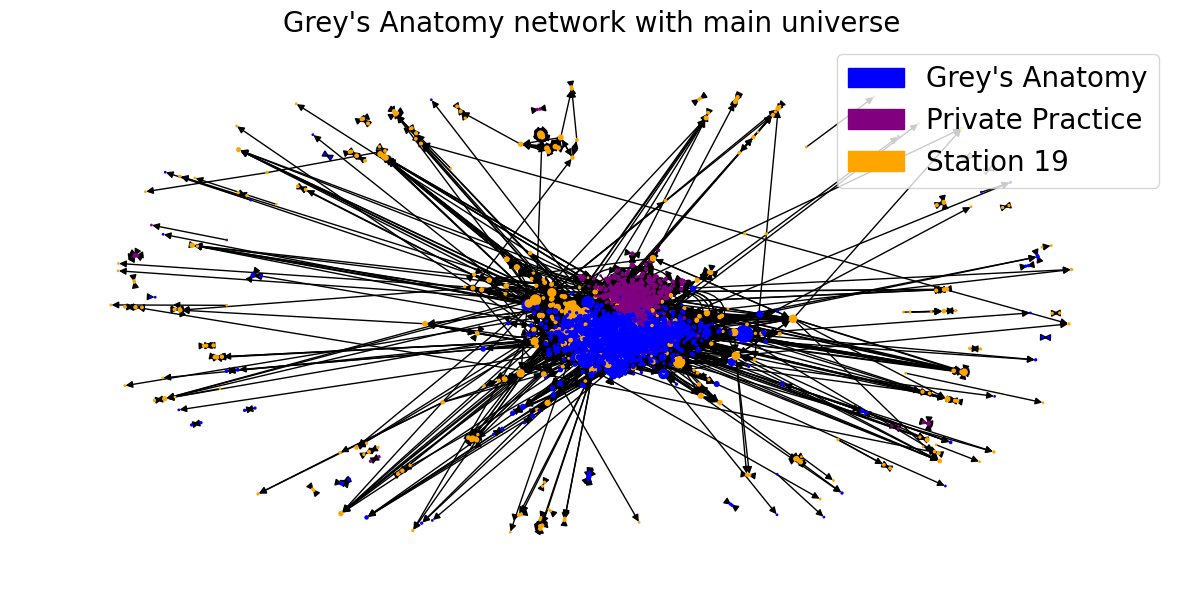

In [16]:
# visualize the network by
# preparing the node colors based on the main show and the node size based on the degree
color_list = ['blue', 'purple', 'orange']
color_code = [node[1]['universe_enc'] for node in ga_net.nodes(data=True)]
node_colors = [color_list[index] for index in color_code]
degrees = [degree[1] for degree in ga_net.degree]

# drawing the network
plt.figure(figsize=(15,7))
plt.title("Grey's Anatomy network with main universe", fontsize=20)
nx.draw(ga_net, node_size=degrees, node_color=node_colors)
blue_patch = mpatches.Patch(color='blue', label= "Grey's Anatomy")
purple_patch = mpatches.Patch(color='purple', label='Private Practice')
orange_patch = mpatches.Patch(color='orange', label='Station 19')
plt.legend(handles=[blue_patch, purple_patch, orange_patch], fontsize=20, loc="upper right")
plt.show()

## 2.3 Degree analyses

Another important step of the network analysis is understanding the degrees further. Therefore, the in- and out-degree distributions will be analyzed as well as the main nodes of the network based on their degrees.

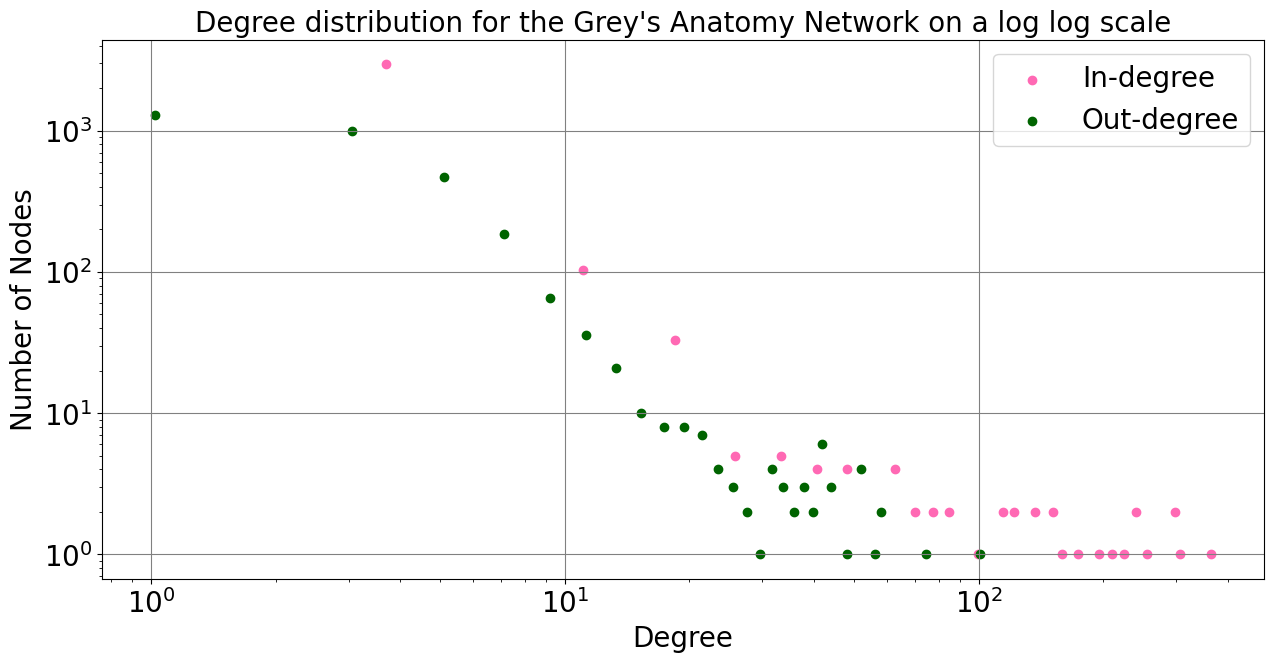

In [17]:
# plot in and out degree distribution on a log log scale
plt.figure(figsize=(15,7))

in_degrees = [ga_net.in_degree(n) for n in ga_net.nodes()]
hist_in = np.histogram(in_degrees, bins=50)
cent_hist_in = 0.5*(hist_in[1][1:]+hist_in[1][:-1])
plt.scatter(cent_hist_in, hist_in[0], color='hotpink', label="In-degree")

out_degrees = [ga_net.out_degree(n) for n in ga_net.nodes()]
hist_out = np.histogram(out_degrees, bins=50)
cent_hist_out = 0.5*(hist_out[1][1:]+hist_out[1][:-1])
plt.scatter(cent_hist_out, hist_out[0], color='darkgreen', label="Out-degree")

plt.title("Degree distribution for the Grey's Anatomy Network on a log log scale",fontsize =20)
plt.xlabel("Degree",fontsize =20)
plt.ylabel("Number of Nodes",fontsize =20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

plt.yscale('log')
plt.xscale('log')

plt.legend(fontsize =20)
plt.grid(which='major', color='grey')
plt.show()

In [18]:
# function for degree calculationw with sorting 
def degree_calculator(nodes, top_range, degree_kind="in"):
    # create dictionairies with the in and out degree and the character name
    degrees_dict = {}
    degrees = []
    if degree_kind == "in":
        for n in nodes:
            degrees_dict[n] = ga_net.in_degree(n)
            degrees.append(ga_net.in_degree(n))
    elif degree_kind == "out":
        for n in nodes:
            degrees_dict[n] = ga_net.out_degree(n)
            degrees.append(ga_net.out_degree(n))
    else:
        print("This is not a value degree specification!")

    
    # sort the dictionaires depending on their values
    sorted_degree_dict = sorted(degrees_dict.items(), key=lambda kv: kv[1], reverse=True)
    
    return dict(sorted_degree_dict[0:top_range]), degrees

In [19]:
# split the nodes based on the main univese
ga_nodes  = [x for x,y in ga_net.nodes(data=True) if y['universe']=="Grey's Anatomy"]
pp_nodes  = [x for x,y in ga_net.nodes(data=True) if y['universe']=="Private Practice"]
s19_nodes =[x for x,y in ga_net.nodes(data=True) if y['universe']=="Station 19"]

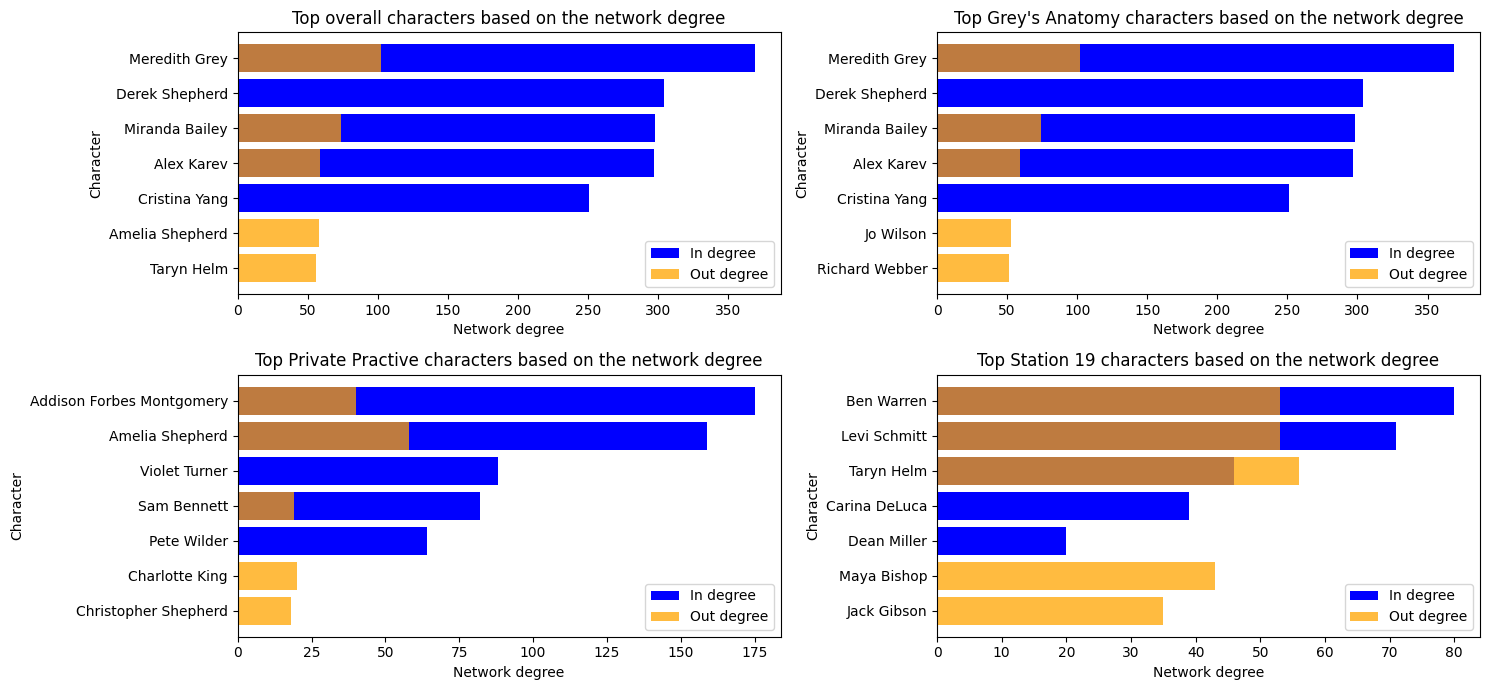

In [20]:
# Top 5  in terms of in degree and out degree for all shows and each show individually
plt.figure(figsize=(15,7))

plt.subplot(2, 2, 1)
plt.title("Top overall characters based on the network degree")
top_5_in, all_in = degree_calculator(ga_net.nodes, 5, "in")
plt.barh(*zip(*top_5_in.items()), color="blue", label="In degree")
top_5_out, all_out = degree_calculator(ga_net.nodes, 5, "out")
plt.barh(*zip(*top_5_out.items()), color='orange', label="Out degree", alpha=0.75)
plt.xlabel("Network degree")
plt.ylabel("Character")
plt.gca().invert_yaxis()
plt.legend()

plt.subplot(2, 2, 2)
plt.title("Top Grey's Anatomy characters based on the network degree")
top_5_in_ga, all_in_ga = degree_calculator(ga_nodes, 5, "in")
plt.barh(*zip(*top_5_in_ga.items()), color="blue", label="In degree")
top_5_out_ga, all_out_ga = degree_calculator(ga_nodes, 5, "out")
plt.barh(*zip(*top_5_out_ga.items()), color='orange', label="Out degree", alpha=0.75)
plt.xlabel("Network degree")
plt.ylabel("Character")
plt.gca().invert_yaxis()
plt.legend()

plt.subplot(2, 2, 3)
plt.title("Top Private Practive characters based on the network degree")
top_5_in_pp, all_in_pp = degree_calculator(pp_nodes, 5, "in")
plt.barh(*zip(*top_5_in_pp.items()), color="blue", label="In degree")
top_5_out_pp, all_out_pp = degree_calculator(pp_nodes, 5, "out")
plt.barh(*zip(*top_5_out_pp.items()), color='orange', label="Out degree", alpha=0.75)
plt.xlabel("Network degree")
plt.ylabel("Character")
plt.gca().invert_yaxis()
plt.legend()

plt.subplot(2, 2, 4)
plt.title("Top Station 19 characters based on the network degree")
top_5_in_s19, all_in_s19 = degree_calculator(s19_nodes, 5, "in")
plt.barh(*zip(*top_5_in_s19.items()), color="blue", label="In degree")
top_5_out_s19, all_out_s19 = degree_calculator(s19_nodes, 5, "out")
plt.barh(*zip(*top_5_out_s19.items()), color='orange', label="Out degree", alpha=0.75)
plt.xlabel("Network degree")
plt.ylabel("Character")
plt.gca().invert_yaxis()
plt.legend()
plt.tight_layout()

## Main findings from the network analysis

The basic network analysis of the Grey's Anatomy network based on the Fandom wikipages shows that
* there are 3124 characters connected through 12824
* the in- and out-degree distributions show a powerlaw relationship which is typcial of a scale free network where most nodes are connected to a few node and there are only few nodes / characters with many connections
* the top overall character is actually Meredith Grey as the name of the show "Grey's Anatomy" indicates
* other top characters based on their degree are characters closely connected to Meredith such as her husband Derek Shepherd, her mentor Miranda Bailey, her person Cristina Yang and her best friend after Cristina Alex Karev
* the top characters of the other two spin off shows are actually the characters who left Grey's Anatomy for a career and personal change starting the spin off. Addison Forbes Montgomery left to join her friends' practice in LA leading to the start of Private Practive and Ben Warren decided to become a firefighter (after being a surgeon) at the Firestation Station 19.



<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=6c50234c-0fc5-40eb-b0ef-2d1cda57d893' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>